#### Multi-Modal

This is a fork of Multimodal RAG with Milvus Standalone running against Ollama with llava:7b

I replaced GPT-4o with Ollama hosted llava:7b.

I replaced the Amazon product data with "ghosts"

* https://github.com/milvus-io/bootcamp/blob/master/bootcamp/tutorials/quickstart/multimodal_rag_with_milvus.ipynb


In [87]:
import warnings
warnings.filterwarnings('ignore')

from tqdm.notebook import tqdm
from PIL import Image
from sentence_transformers import SentenceTransformer
from pymilvus import MilvusClient
import requests
from pymilvus import (
   utility,
   FieldSchema, CollectionSchema, DataType,
   Collection, AnnSearchRequest, RRFRanker, connections,
)

In [88]:
from pymilvus import connections
from pymilvus import utility
from pymilvus import FieldSchema, CollectionSchema, DataType, Collection
from pymilvus import MilvusClient

SERVER_IP = "192.168.1.166"
MILVUS_URL = "http://" + str(SERVER_IP) + ":19530" 
milvus_client = MilvusClient(uri=MILVUS_URL)
connections.connect(uri=MILVUS_URL)

DEBUG:pymilvus.milvus_client.milvus_client:Created new connection using: cf36c7b6a6184aaaac029188b5edaec9


In [89]:
from IPython.display import display
from PIL import Image
import requests
from io import BytesIO
from pymilvus import AnnSearchRequest, RRFRanker, WeightedRanker
import time
from pymilvus import WeightedRanker
from IPython.display import display, Markdown

In [8]:
#!wget https://huggingface.co/BAAI/bge-visualized/resolve/main/Visualized_base_en_v1.5.pth

In [64]:
!pip3 install -q --upgrade pymilvus openai datasets opencv-python timm einops ftfy peft tqdm

In [71]:
#!pip install git+https://github.com/FlagOpen/FlagEmbedding.git

In [90]:
import torch
from FlagEmbedding.visual.modeling import Visualized_BGE

#### Multimodal Encoder
class Encoder:
    def __init__(self, model_name: str, model_path: str):
        self.model = Visualized_BGE(model_name_bge=model_name, model_weight=model_path)
        self.model.eval()

    def encode_query(self, image_path: str, text: str) -> list[float]:
        with torch.no_grad():
            query_emb = self.model.encode(image=image_path, text=text)
        return query_emb.tolist()[0]

    def encode_image(self, image_path: str) -> list[float]:
        with torch.no_grad():
            query_emb = self.model.encode(image=image_path)
        return query_emb.tolist()[0]


model_name = "BAAI/bge-base-en-v1.5"
model_path = "./Visualized_base_en_v1.5.pth"  # Change to your own value if using a different model path
encoder = Encoder(model_name, model_path)

In [38]:
import os
from tqdm import tqdm
from glob import glob

# Generate embeddings for the image dataset
data_dir = (
    "/Users/timothyspann/Desktop/standardghosts"  
)
image_list1 = glob(
    os.path.join(data_dir, "*.jpg")
)  

data_dir2 = (
    "/Users/timothyspann/Desktop/ghosts"  
)
image_list2 = glob(
    os.path.join(data_dir2, "*.jpg")
    ) 
image_list3 = glob(
    os.path.join(data_dir2, "*.png")
    ) 

image_list = image_list1 + image_list2 + image_list3

image_dict = {}
for image_path in tqdm(image_list, desc="Generating image embeddings: "):
    try:
        image_dict[image_path] = encoder.encode_image(image_path)
    except Exception as e:
        print(f"Failed to generate embedding for {image_path}. Skipped.")
        continue
print("Number of encoded images:", len(image_dict))

Generating image embeddings: 100%|███████████████████████████| 158/158 [00:30<00:00,  5.19it/s]

Number of encoded images: 158


In [39]:
from pymilvus import MilvusClient

dim = len(list(image_dict.values())[0])
collection_name = "ghosts2"

if milvus_client.has_collection(collection_name=collection_name):
    print(collection_name + " exists")
else:
    milvus_client.create_collection(
        collection_name=collection_name,
        auto_id=True,
        dimension=dim,
        enable_dynamic_field=True,
    )

# Insert data into collection
milvus_client.insert(
    collection_name=collection_name,
    data=[{"image_path": k, "vector": v} for k, v in image_dict.items()],
)

DEBUG:pymilvus.milvus_client.milvus_client:Successfully created collection: ghosts2
DEBUG:pymilvus.milvus_client.milvus_client:Successfully created an index on collection: ghosts2


{'insert_count': 158, 'ids': [453043247072627587, 453043247072627588, 453043247072627589, 453043247072627590, 453043247072627591, 453043247072627592, 453043247072627593, 453043247072627594, 453043247072627595, 453043247072627596, 453043247072627597, 453043247072627598, 453043247072627599, 453043247072627600, 453043247072627601, 453043247072627602, 453043247072627603, 453043247072627604, 453043247072627605, 453043247072627606, 453043247072627607, 453043247072627608, 453043247072627609, 453043247072627610, 453043247072627611, 453043247072627612, 453043247072627613, 453043247072627614, 453043247072627615, 453043247072627616, 453043247072627617, 453043247072627618, 453043247072627619, 453043247072627620, 453043247072627621, 453043247072627622, 453043247072627623, 453043247072627624, 453043247072627625, 453043247072627626, 453043247072627627, 453043247072627628, 453043247072627629, 453043247072627630, 453043247072627631, 453043247072627632, 453043247072627633, 453043247072627634, 4530432470

search latency: 0.2713 seconds




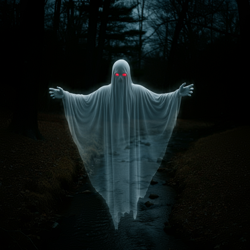

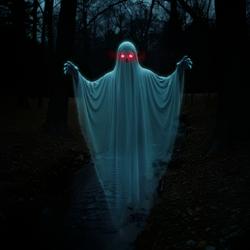

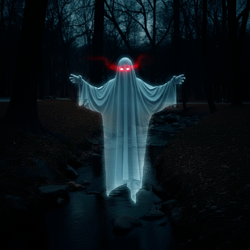

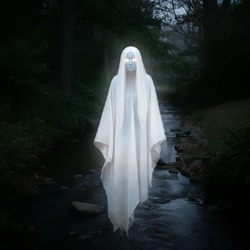

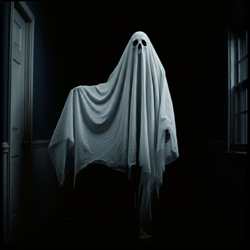

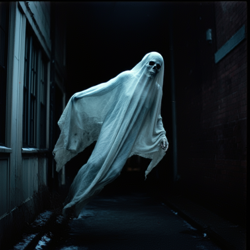

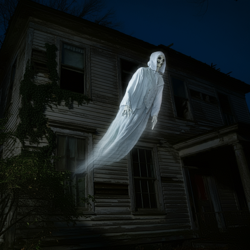

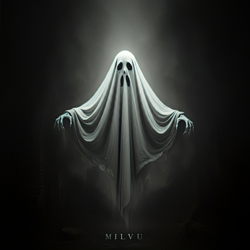

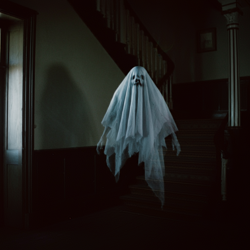

['/Users/timothyspann/Desktop/ghosts/river3.jpg', '/Users/timothyspann/Desktop/ghosts/river1.jpg', '/Users/timothyspann/Desktop/ghosts/river4.jpg', '/Users/timothyspann/Desktop/ghosts/river7.jpg', '/Users/timothyspann/Desktop/ghosts/ghost999.jpg', '/Users/timothyspann/Desktop/ghosts/image_fx_ (8).jpg', '/Users/timothyspann/Desktop/standardghosts/v6.jpg', '/Users/timothyspann/Desktop/ghosts/ghost62.jpg', '/Users/timothyspann/Desktop/ghosts/home2.jpg']


In [46]:
query_image = "/Users/timothyspann/Desktop/ghosts/river1.jpg" 
query_text = "A white floating ghost"

t0 = time.time()

# Generate query embedding given image and text instructions
query_vec = encoder.encode_query(image_path=query_image, text=query_text)

search_results = milvus_client.search(
        data=[query_vec],
    collection_name="ghosts2",
    limit=9,  # Max number of search results to return
    output_fields=["image_path"],
    search_params={"metric_type": "COSINE", "params": {}},
)[0]

t1 = time.time()
print(f"search latency: {round(t1-t0, 4)} seconds\n\n")
# print(results)

retrieved_images = []

for data in search_results:
    img = Image.open(data["entity"]["image_path"])
    img = img.resize((250, 250))
    retrieved_images.append(data["entity"]["image_path"])
    display(img)

print(retrieved_images)


In [47]:
import numpy as np
import cv2

img_height = 300
img_width = 300
row_count = 3


def create_panoramic_view(query_image_path: str, retrieved_images: list) -> np.ndarray:
    """
    creates a 5x5 panoramic view image from a list of images

    args:
        images: list of images to be combined

    returns:
        np.ndarray: the panoramic view image
    """
    panoramic_width = img_width * row_count
    panoramic_height = img_height * row_count
    panoramic_image = np.full(
        (panoramic_height, panoramic_width, 3), 255, dtype=np.uint8
    )

    # create and resize the query image with a blue border
    query_image_null = np.full((panoramic_height, img_width, 3), 255, dtype=np.uint8)
    query_image = Image.open(query_image_path).convert("RGB")
    query_array = np.array(query_image)[:, :, ::-1]
    resized_image = cv2.resize(query_array, (img_width, img_height))

    border_size = 10
    blue = (255, 0, 0)  # blue color in BGR
    bordered_query_image = cv2.copyMakeBorder(
        resized_image,
        border_size,
        border_size,
        border_size,
        border_size,
        cv2.BORDER_CONSTANT,
        value=blue,
    )

    query_image_null[img_height * 2 : img_height * 3, 0:img_width] = cv2.resize(
        bordered_query_image, (img_width, img_height)
    )

    # add text "query" below the query image
    text = "query"
    font_scale = 1
    font_thickness = 2
    text_org = (10, img_height * 3 + 30)
    cv2.putText(
        query_image_null,
        text,
        text_org,
        cv2.FONT_HERSHEY_SIMPLEX,
        font_scale,
        blue,
        font_thickness,
        cv2.LINE_AA,
    )

    # combine the rest of the images into the panoramic view
    retrieved_imgs = [
        np.array(Image.open(img).convert("RGB"))[:, :, ::-1] for img in retrieved_images
    ]
    for i, image in enumerate(retrieved_imgs):
        image = cv2.resize(image, (img_width - 4, img_height - 4))
        row = i // row_count
        col = i % row_count
        start_row = row * img_height
        start_col = col * img_width

        border_size = 2
        bordered_image = cv2.copyMakeBorder(
            image,
            border_size,
            border_size,
            border_size,
            border_size,
            cv2.BORDER_CONSTANT,
            value=(0, 0, 0),
        )
        panoramic_image[
            start_row : start_row + img_height, start_col : start_col + img_width
        ] = bordered_image

        # add red index numbers to each image
        text = str(i)
        org = (start_col + 50, start_row + 30)
        (font_width, font_height), baseline = cv2.getTextSize(
            text, cv2.FONT_HERSHEY_SIMPLEX, 1, 2
        )

        top_left = (org[0] - 48, start_row + 2)
        bottom_right = (org[0] - 48 + font_width + 5, org[1] + baseline + 5)

        cv2.rectangle(
            panoramic_image, top_left, bottom_right, (255, 255, 255), cv2.FILLED
        )
        cv2.putText(
            panoramic_image,
            text,
            (start_col + 10, start_row + 30),
            cv2.FONT_HERSHEY_SIMPLEX,
            1,
            (0, 0, 255),
            2,
            cv2.LINE_AA,
        )

    # combine the query image with the panoramic view
    panoramic_image = np.hstack([query_image_null, panoramic_image])
    return panoramic_image

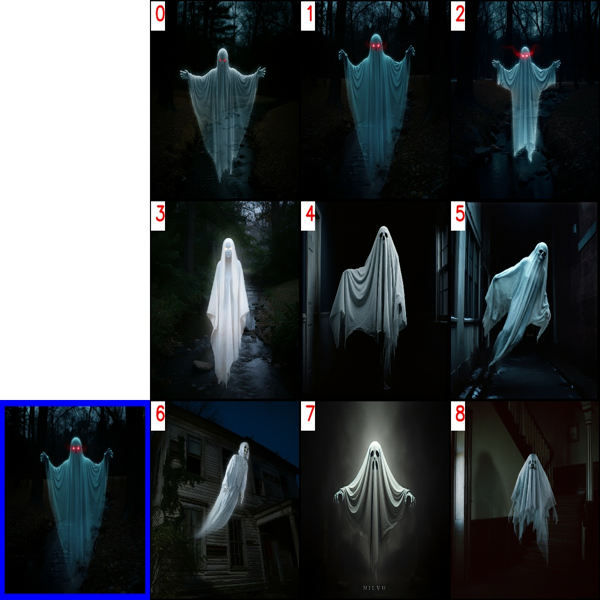

In [77]:
from PIL import Image

data_dir = "/Users/timothyspann/Desktop/ghosts/"

combined_image_path = os.path.join(data_dir, "combined_image.jpg")
panoramic_image = create_panoramic_view(query_image, retrieved_images)
cv2.imwrite(combined_image_path, panoramic_image)

combined_image = Image.open(combined_image_path)
show_combined_image = combined_image.resize((600, 600))
#show_combined_image.show()
display(show_combined_image)

In [75]:
import requests
import base64
import ollama

def generate_ranking_explanation(
    combined_image_path: str, caption: str, infos: dict = None
) -> tuple[list[int], str]:
    with open(combined_image_path, "rb") as image_file:
        base64_image = base64.b64encode(image_file.read()).decode("utf-8")

    information = (
        "You are responsible for ranking results for a Composed Image Retrieval. "
        "The user retrieves an image with an 'instruction' indicating their retrieval intent. "
        "For example, if the user queries a red car with the instruction 'change this car to blue,' a similar type of car in blue would be ranked higher in the results. "
        "Now you would receive instruction and query image with blue border. Every item has its red index number in its top left. Do not misunderstand it. "
        f"User instruction: {caption} \n\n"
    )

    # add additional information for each image
    if infos:
        for i, info in enumerate(infos["product"]):
            information += f"{i}. {info}\n"

    information += (
        "Provide a new ranked list of indices from most suitable to least suitable, followed by an explanation for the top 1 most suitable item only. "
        "The format of the response has to be 'Ranked list: []' with the indices in brackets as integers, followed by 'Reasons:' plus the explanation why this most fit user's query intent."
    )

    headers = { } 

    payload = {
        "model": "llava:7b",
        "messages": [
            {
                "role": "user",
                "content": [
                    {"type": "text", "text": information},
                    {
                        "type": "image_url",
                        "image_url": {"url": f"data:image/jpeg;base64,{base64_image}"},
                    },
                ],
            }
        ],
        "max_tokens": 30000,
    }

    response = requests.post(
        "http://localhost:11434/v1/chat/completions", headers=headers, json=payload
    )

    #print(response)
    #print(response.json())
    result = response.json()["choices"][0]["message"]["content"]

    print(result)
    # parse the ranked indices from the response
    start_idx = result.find("[")
    end_idx = result.find("]")
    ranked_indices_str = result[start_idx + 1 : end_idx].split(",")
    ranked_indices = [int(index.strip()) for index in ranked_indices_str]

    # extract explanation
    explanation = result[end_idx + 1 :].strip()
    return ranked_indices, explanation

In [76]:
ranked_indices, explanation = generate_ranking_explanation(
    combined_image_path, query_text
)

 Ranked list: [1, 5, 2, 6, 3, 7]

Reasons:

* The top-ranked image shows a ghostly figure floating with its arms stretched out. This is the most suitable image for the user's query as it presents a "white floating ghost" as described and seems to fit well with the context of an instruction to transform the car to blue, which involves changing the visual composition. The image captures this concept effectively as the figure itself appears ethereal and unbound by any physical constraints, much like how user intent might be about altering the appearance of a car beyond its real-world limitations. 


Reasons:

* The top-ranked image shows a ghostly figure floating with its arms stretched out. This is the most suitable image for the user's query as it presents a "white floating ghost" as described and seems to fit well with the context of an instruction to transform the car to blue, which involves changing the visual composition. The image captures this concept effectively as the figure itself appears ethereal and unbound by any physical constraints, much like how user intent might be about altering the appearance of a car beyond its real-world limitations.


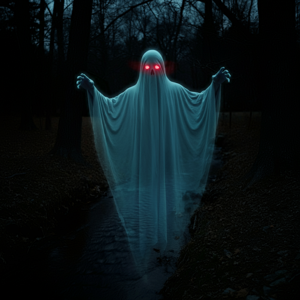

In [78]:
print(explanation)

best_index = ranked_indices[0]
best_img = Image.open(retrieved_images[best_index])
best_img = best_img.resize((300, 300))
display(best_img)